# Audit the new version of the persistence image class to ensure functionality in the scikit-TDA API and compare the speeds of the two implementations

## Additional native functionality:
* Images are no longer restricted to square regions of the persistence plane
* Non-isotrapic Gaussians are now supported
* One-parameter, nonlinear power functions now supported as weight functions

## Code updates:
* Summed-area table calculation of image

In [1]:
import numpy as np
import timeit
import matplotlib.pyplot as plt
from persim import PersImage
from persim import PersistenceImager

In [2]:
def random_pd(num_pairs=1000, birth_range=(0.0, 1.0), persistence_range=(0.0, 1.0), seed=None):
    """
    Generate a random persistence diagram over a specified range of the birth-death or birth-persistence plane
    """
    np.random.seed(seed)
    
    birth = np.random.uniform(low=birth_range[0], high=birth_range[1], size=(num_pairs,))
    persistence_range = np.random.uniform(low=persistence_range[0], high=persistence_range[1], size=(num_pairs,))
    death = persistence_range + birth
    pers_dgm = np.vstack((birth, death))
        
    return pers_dgm.transpose()

In [70]:
pixel_sizes = [.2, .1, .05, .02, .01, .005]
pixel_dimensions = [5, 10, 20, 50, 100, 200]

# Generate some random Persistence diagrams
num_pds = 100
pds = [random_pd(num_pairs=1000, birth_range=(0.0,1.0), persistence_range=(0.0,1.0), seed=0) for _ in range(num_pds)]

import timeit

time_reduction = np.empty(len(pixel_sizes), dtype=float)
time_old = np.empty(len(pixel_sizes), dtype=float)
time_new = np.empty(len(pixel_sizes), dtype=float)
for i in range(len(pixel_sizes)):
    # Construct a default PersistenceImager object
    persimager_new = PersistenceImager(pixel_size=pixel_sizes[i])
    print(persimager_new.resolution)
    
    # Construct an equivalent PersImage object
    persimager_old = PersImage(pixels=(pixel_dimensions[i], pixel_dimensions[i]), spread=1.0, specs={
                "maxBD": 1,
                "minBD": 0
            }, weighting_type="linear", kernel_type="gaussian")
    
    # Transform random persistence
    start_time_new = timeit.default_timer()
    pi_new = persimager_new.transform(pds, skew=True, n_jobs=None)
    elapsed_new = timeit.default_timer() - start_time_new

    start_time_old = timeit.default_timer()
    pi_old = persimager_old.transform(pds)
    elapsed_old = timeit.default_timer() - start_time_old

    #print('New code took %f sec.' %elapsed_new)
    #print('Old code took %f sec.' %elapsed_old)
    #print('%f time reduction.' %((elapsed_new-elapsed_old) / elapsed_old))
    time_old[i] = elapsed_old
    time_new[i] = elapsed_new
    time_reduction[i] = -(elapsed_new-elapsed_old) / elapsed_old

(5, 5)
PersImage(pixels=(5, 5), spread=1.0, specs={'maxBD': 1, 'minBD': 0}, kernel_type="gaussian", weighting_type="linear")
(10, 10)
PersImage(pixels=(10, 10), spread=1.0, specs={'maxBD': 1, 'minBD': 0}, kernel_type="gaussian", weighting_type="linear")
(20, 20)
PersImage(pixels=(20, 20), spread=1.0, specs={'maxBD': 1, 'minBD': 0}, kernel_type="gaussian", weighting_type="linear")
(50, 50)
PersImage(pixels=(50, 50), spread=1.0, specs={'maxBD': 1, 'minBD': 0}, kernel_type="gaussian", weighting_type="linear")
(100, 100)
PersImage(pixels=(100, 100), spread=1.0, specs={'maxBD': 1, 'minBD': 0}, kernel_type="gaussian", weighting_type="linear")
(200, 200)
PersImage(pixels=(200, 200), spread=1.0, specs={'maxBD': 1, 'minBD': 0}, kernel_type="gaussian", weighting_type="linear")


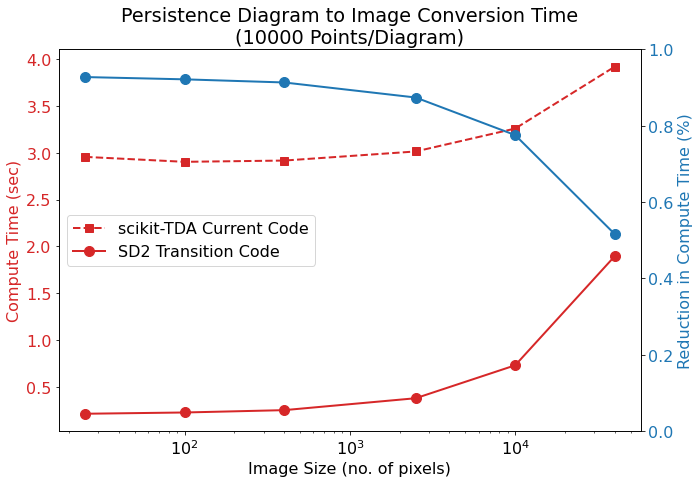

In [71]:
fig, ax1 = plt.subplots(figsize=(10,7))
plt.rcParams.update({'font.size': 16})

plt.title('Persistence Diagram to Image Conversion Time\n(1000 Points/Diagram)')
color = 'tab:red'
ax1.set_xlabel('Image Size (no. of pixels)')
ax1.set_ylabel('Compute Time (sec)', color=color)
ax1.plot([pixel_dimension**2 for pixel_dimension in pixel_dimensions], time_old/100, '--', marker='s', markersize=8, color=color, linewidth=2, label='scikit-TDA Current Code')
ax1.plot([pixel_dimension**2 for pixel_dimension in pixel_dimensions], time_new/100, marker='.', markersize=20, color=color, linewidth=2, label='SD2 Transition Code')
ax1.tick_params(axis='y', labelcolor=color)
plt.xscale('log')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylim(0,1)

color = 'tab:blue'
ax2.set_ylabel('Reduction in Compute Time (%)', color=color)  # we already handled the x-label with ax1
ax2.plot([pixel_dimension**2 for pixel_dimension in pixel_dimensions], time_reduction, linewidth=2, marker='.', markersize=20, color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax1.legend(loc='center left')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('dgm_to_img_time_1000-pairs.svg')